# Inference Homework 5
## Alex Pine
## 2015/11/21

In [ ]:
# TODO Question 1, 2, 3

## Question 4
I collaborated with Peter Li on thsi problem.

I've graphed four covariance functions:
1) Exponential (not differentiable, not compact)
2) Squared Exponential (differentiable, not compact)
3) Spherical (not differentiable, compact)
4) Linear (differentiable, not compact)

Since the first three is isotrophic, I graphed the covariance values by the distance between the two points $x_i$ and $y_i$, instead of plotting the covariance value for each combination of the two. 

Since the linear covariance function is not isotrophic, I plotted its value for each pair of $x_i$ and $y_i$ on a 3d graph. Note the second set of samples for the linear covariance function doesn't come out to be a line, because in that case, the tau paramater is zero, which makes the covariance function a constant value, leading to non-linear samples.

In [435]:
# Covariance functions

import itertools
import math
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline  

# 1) Exponential (not differentiable, not compact)
def make_exp_covar_fn(tau, l):
    def exp_covar_fn(x, y):
        return tau**2 * math.exp(-np.linalg.norm(x - y) / (2*l))
    return exp_covar_fn

# 2) Squared Exponential (differentiable, not compact)
def make_squared_exp_covar_fn(tau, l):
    def squared_exp_covar_fn(x, y):
        diff = x - y
        return tau**2 * math.exp(-np.inner(diff, diff) / (2*(l**2)))
    return squared_exp_covar_fn

# 3) Spherical (not differentiable, compact)
def make_spherical_covar_fn(tau, theta):
    def spherical_covar_fn(x, y):
        dist = np.linalg.norm(x - y)
        if dist <= theta:
            return tau**2 * (1 - 3*dist/(2*theta) + dist**3/(2*theta**3))
        else:
            return 0.0
    return spherical_covar_fn

# 4) Linear (differentiable, not compact)
def make_linear_covar_fn(sigma, tau, c):
    def linear_covar_fn(x, y):
        return sigma**2 + tau**2 * np.inner(x - c, y - c)
    return linear_covar_fn


In [317]:
# This samples from a multivariate Gaussian distribution, with a zero mean 
# value, and a covariance matrix determined by the convariance function 
# and the x values parameters.
def sample_gp(xs, covar_fn):
    mean_vec = np.zeros(len(xs))
    gram_matrix = np.zeros((len(xs), len(xs)))
    for i in range(len(xs)):
        x_i = xs[i]
        for j in range(0, i):
            x_j = xs[j]
            gram_matrix[i][j] = covar_fn(x_i, x_j)
            gram_matrix[j][i] = gram_matrix[i][j]
        gram_matrix[i][i] = covar_fn(x_i, x_i)
    samples = np.random.multivariate_normal(mean_vec, gram_matrix)
    return samples
   

In [403]:
# This function plots isotropic covariance functions.
def plot_iso_covar_fn(title, covar_fn_maker, param_list, param_names):
    covar_fn_list = [covar_fn_maker(*params) for params in param_list]
    xs = np.zeros(100)
    ys = np.arange(0.0, 1.0, 0.01)
    
    covar_vals = []
    sample_vals = []
    for covar_fn in covar_fn_list:
        covar_vals.append([covar_fn(x, y) for x, y in zip(xs, ys)])
        sample_vals.append(sample_gp(ys, covar_fn))
        
    diffs = ys - xs    
    fig = plt.figure(1, figsize=(18, 6))
    # Covariance values
    plt.subplot(1, 2, 1)
    plt.title(title + ': Covariance function values')
    plt.xlabel('y_i - x_i')
    plt.ylabel('covariance(x_i, y_i)')
    lines = []
    for params, covar_val in zip(param_list, covar_vals):
        param_str = ", ".join([name + ": " + str(param) 
                               for name, param in zip(param_names, params)])
        line, = plt.plot(diffs, covar_val)
        lines.append(param_str)
    plt.legend(lines)
    # Gaussian Process samples
    plt.subplot(1, 2, 2)
    plt.title(title + ': GP Samples')
    for sample_val in sample_vals:
        plt.plot(diffs, sample_val)
    plt.xlabel('distance')
    plt.ylabel('Guassian Sample')    
    plt.show()    

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


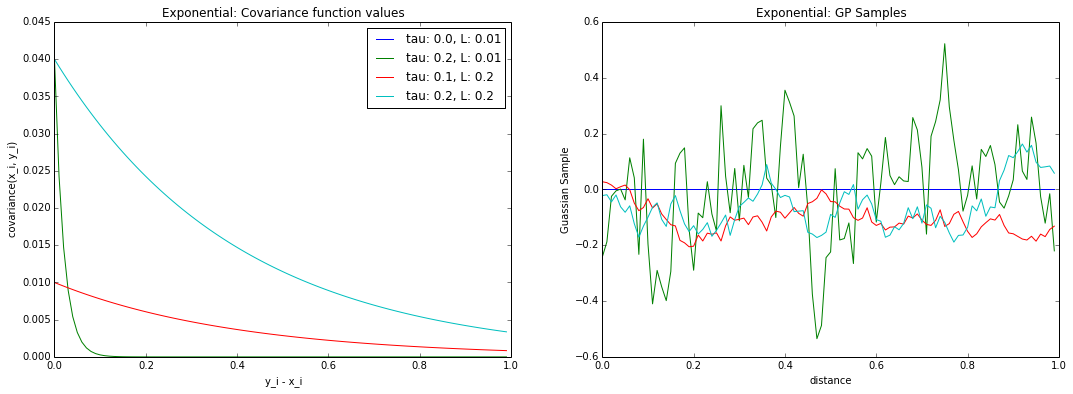

In [410]:
# L can't be zero or you get a divide by zero error
exp_params = [(0.0, 0.01), (0.2, 0.01), (0.1, 0.2), (0.2, 0.2)]
plot_iso_covar_fn("Exponential", make_exp_covar_fn, 
                  exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


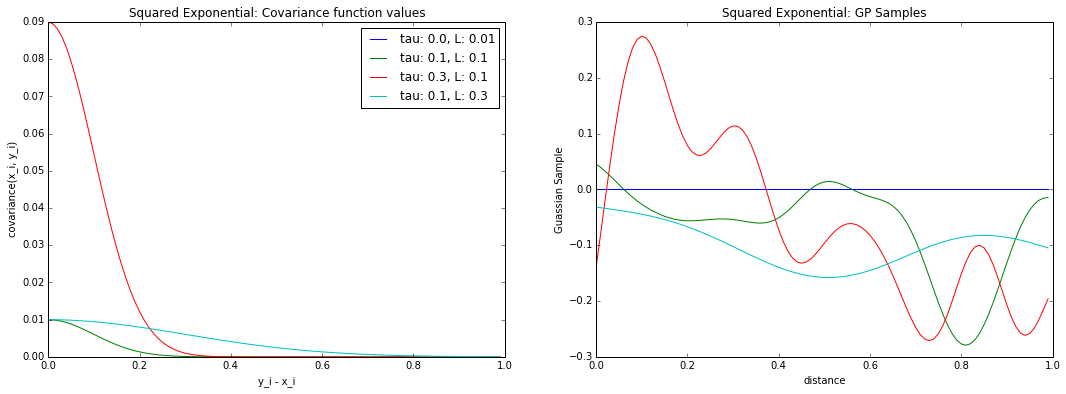

In [426]:
squared_exp_params = [(0.0, 0.01), (0.1, 0.1), (0.3, 0.1), (0.1, 0.3)]
plot_iso_covar_fn("Squared Exponential", make_squared_exp_covar_fn, 
                  squared_exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


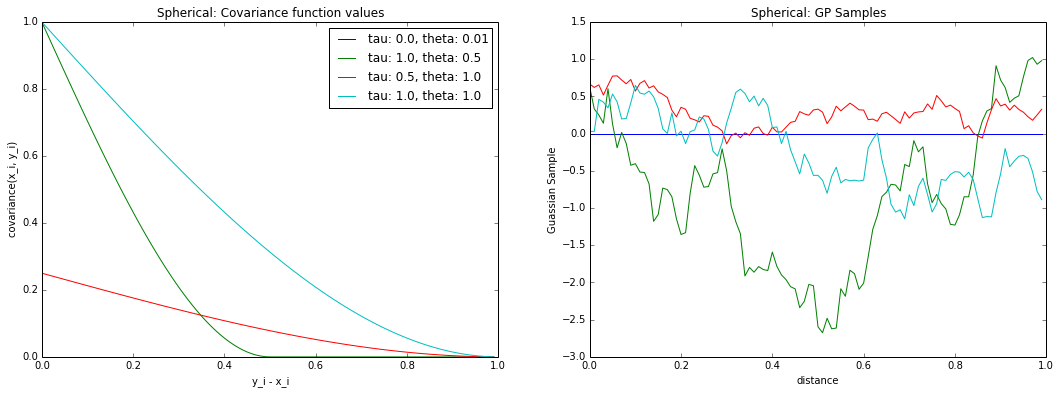

In [429]:
spherical_params = [(0.0, 0.01), (1.0, 0.5), (0.5, 1.0), (1.0, 1.0)]
plot_iso_covar_fn("Spherical", make_spherical_covar_fn, 
                  spherical_params, ['tau', 'theta'])

In [433]:
# This function plots non-isotropic covariance functions.
def plot_non_iso_covar_fn(title, covar_fn_maker, params, param_names):
    covar_fn = covar_fn_maker(*params)
    
    xs = np.arange(0.0, 1.0, 0.01)
    ys = xs
    
    # Find covariance function values, get them ready to be plotted.            
    xx, yy = np.meshgrid(xs, ys)
    zs = np.array([covar_fn(x, y) 
                   for x, y in zip(np.ravel(xx), np.ravel(yy))])
    covar_val = zs.reshape(xx.shape)
    
    # Sample from the Normal distribution
    sample_val = sample_gp(ys, covar_fn)
    
    # Plotting
    fig = plt.figure(1, figsize=(18, 6))
    # Covariance values
    plt.subplot(1, 2, 1) 
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(xx, yy, covar_val, cmap=cm.coolwarm)
    ax.set_title(title + ': Covariance function values') 
    ax.set_xlabel('x_i')
    ax.set_ylabel('y_i')
    ax.set_zlabel('Covariance')

    # Gaussian Process samples
    plt.subplot(1, 2, 2)
    plt.title(title + ': GP Samples')
    plt.plot(xs, sample_val)
    plt.xlabel('x_i')
    plt.ylabel('Guassian Sample')
    # Legend on the right this time, since it's 2d
    param_str = ", ".join([name + ": " + str(param) 
                          for name, param in zip(param_names, params)])
    plt.legend([param_str])    

    plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


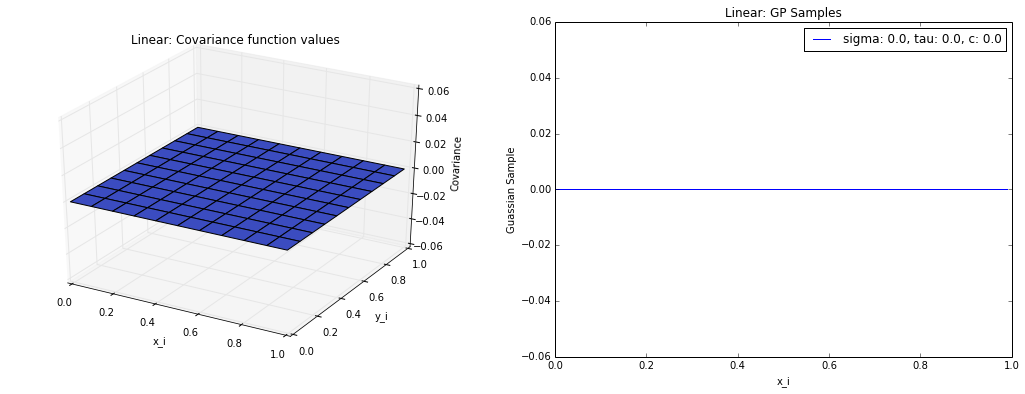

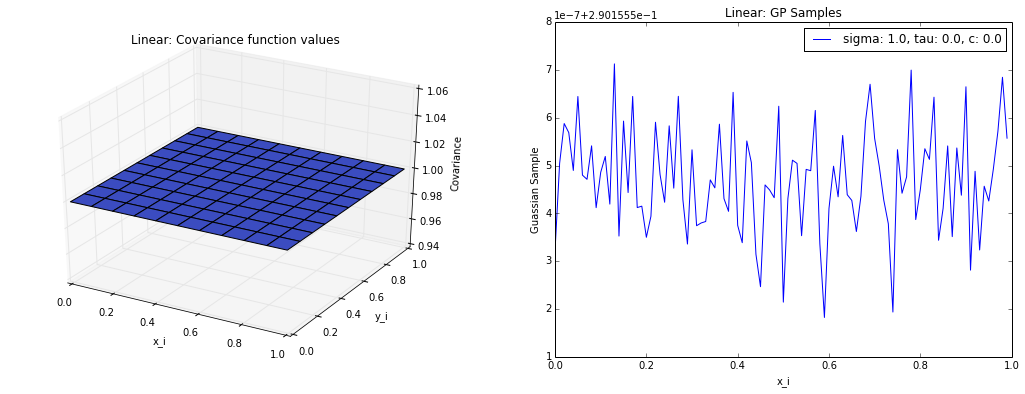

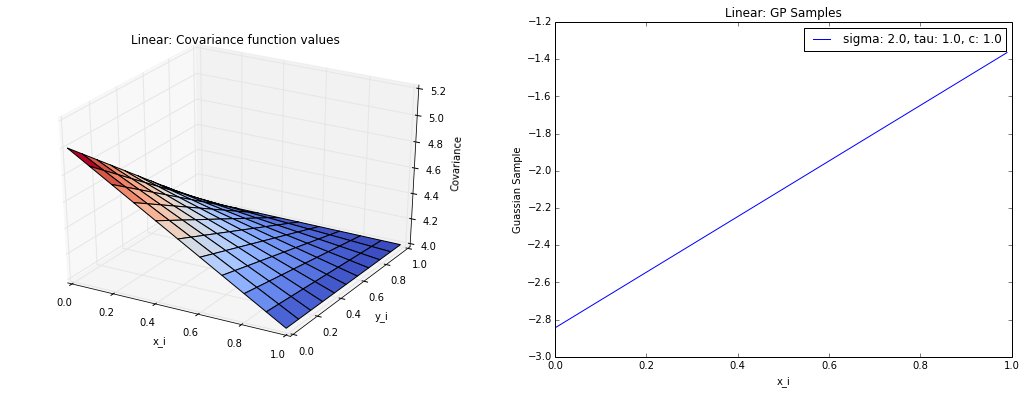

In [434]:
linear_param_list = [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0), (2.0, 1.0, 1.0)]
for linear_params in linear_param_list:
    plot_non_iso_covar_fn("Linear", make_linear_covar_fn, 
                          linear_params, ['sigma', 'tau', 'c'])